In [1]:
# remove warning message
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# required library
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from local_utils import detect_lp
from os.path import splitext,basename
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from sklearn.preprocessing import LabelEncoder
import glob

### Part 1: Extract license plate from sample image

In [2]:
def load_model(path):
    try:
        path = splitext(path)[0]
        with open('%s.json' % path, 'r') as json_file:
            model_json = json_file.read()
        model = model_from_json(model_json, custom_objects={})
        model.load_weights('%s.h5' % path)
        print("Loading model successfully...")
        return model
    except Exception as e:
        print(e)

In [3]:
wpod_net_path = "wpod-net.json"
wpod_net = load_model(wpod_net_path)

Loading model successfully...


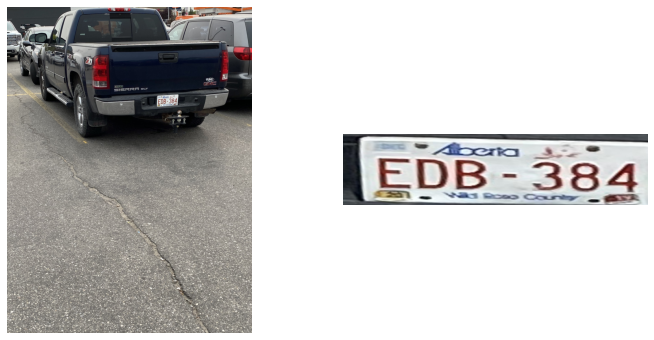

In [199]:
def preprocess_image(image_path,resize=False):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img / 255
    if resize:
        img = cv2.resize(img, (224,224))
    return img

def get_plate(image_path, Dmax=600, Dmin = 400):
    vehicle = preprocess_image(image_path)
    ratio = float(max(vehicle.shape[:2])) / min(vehicle.shape[:2])
    side = int(ratio * Dmin)
    bound_dim = min(side, Dmax)
    _ , LpImg, _, cor = detect_lp(wpod_net, vehicle, bound_dim, lp_threshold=0.5)
    return vehicle, LpImg, cor

test_image_path = "Plate_examples/alberta_licence/IMG_0208.jpg"
vehicle, LpImg,cor = get_plate(test_image_path)

fig = plt.figure(figsize=(12,6))
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[0])
plt.axis(False)
plt.imshow(vehicle)
grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
fig.add_subplot(grid[1])
plt.axis(False)
plt.imshow(LpImg[0])

## Part 2: Segementing license characters

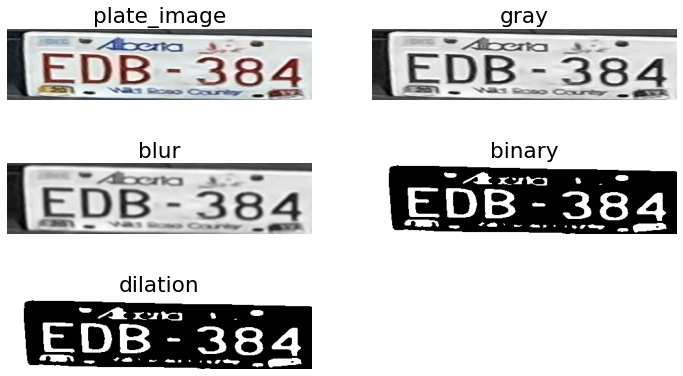

In [200]:
if (len(LpImg)): #check if there is at least one license image
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)

    
# visualize results    
fig = plt.figure(figsize=(12,7))
plt.rcParams.update({"font.size":18})
grid = gridspec.GridSpec(ncols=2,nrows=3,figure = fig)
plot_image = [plate_image, gray, blur, binary,thre_mor]
plot_name = ["plate_image","gray","blur","binary","dilation"]

for i in range(len(plot_image)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.title(plot_name[i])
    if i ==0:
        plt.imshow(plot_image[i])
    else:
        plt.imshow(plot_image[i],cmap="gray")

# plt.savefig("threshding.png", dpi=300)

(408, 47, 45, 43)
[20 17 19 -1] 

(351, 46, 44, 43)
[23 18 21 -1] 

(293, 45, 45, 42)
[24 20 -1 -1] 

(173, 41, 48, 45)
[27 23 25 -1] 

(114, 40, 48, 45)
[29 24 28 -1] 

(55, 39, 49, 46)
[30 27 -1 -1] 

Detect 6 letters...


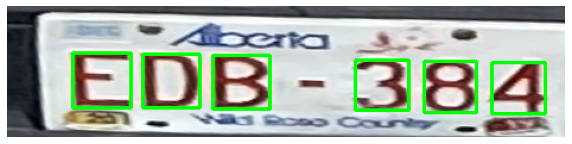

In [201]:
# Create sort_contours() function to grab the contour of each digit from left to right
def sort_contours(cnts, reverse = False):
    i = 0
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    return cnts
# cont=0
# cont, _  = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cont, hierarchy  = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)

cont_new = []
hierarchy_new = []
H, W =binary.shape
for index, c in enumerate(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    if x<=1 or (W-x-w)<=1 or y<=1 or (H-y-h)<=1: continue   # Remove the contours close to the edge of image
    
    ratio = h/w
#     if 1E-100<=ratio<=1E100:
    if 0.6<=ratio<=5: # Only select contour with defined ratio
        if h/plate_image.shape[0]>=0.3: # Select contour which has the height larger than 50% of the plate
            if hierarchy[0][index][3]==-1:  # Neglect the inner contors of the characters.
                cont_new.append(c)
                hierarchy_new.append(hierarchy[0][index])

for i in range(len(cont_new)):            
    print (cv2.boundingRect(cont_new[i]))
    print (hierarchy_new[i], '\n')
    



# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 40, 60

for c in sort_contours(cont_new):
    (x, y, w, h) = cv2.boundingRect(c)
    # Draw bounding box arroung digit number
    cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

    # Sperate number and gibe prediction
    curr_num = thre_mor[y:y+h,x:x+w]
    curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
    curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)

In [165]:
binary.shape

(200, 280)

(305, 109, 8, 1)
[ 1 -1 -1 -1] 

(378, 101, 17, 6)
[ 2  0 -1 -1] 

(308, 97, 8, 5)
[ 3  1 -1 -1] 

(297, 97, 3, 3)
[ 4  2 -1 -1] 

(118, 97, 17, 5)
[ 5  3 -1 -1] 

(320, 96, 9, 6)
[ 6  4 -1 -1] 

(280, 96, 3, 3)
[ 7  5 -1 -1] 

(263, 96, 6, 4)
[ 8  6 -1 -1] 

(219, 96, 12, 3)
[ 9  7 -1 -1] 

(332, 95, 27, 8)
[10  8 -1 -1] 

(243, 95, 16, 5)
[11  9 -1 -1] 

(202, 94, 3, 3)
[12 10 -1 -1] 

(402, 93, 52, 15)
[14 11 13 -1] 

(437, 97, 6, 5)
[-1 -1 -1 12] 

(177, 92, 16, 7)
[15 12 -1 -1] 

(164, 92, 9, 6)
[16 14 -1 -1] 

(50, 88, 53, 11)
[17 15 -1 -1] 

(247, 62, 20, 6)
[18 16 -1 -1] 

(408, 47, 45, 43)
[20 17 19 -1] 

(421, 61, 19, 15)
[-1 -1 -1 18] 

(351, 46, 44, 43)
[23 18 21 -1] 

(360, 67, 27, 19)
[22 -1 -1 20] 

(361, 50, 24, 14)
[-1 21 -1 20] 

(293, 45, 45, 42)
[24 20 -1 -1] 

(173, 41, 48, 45)
[27 23 25 -1] 

(184, 65, 27, 17)
[26 -1 -1 24] 

(183, 46, 26, 16)
[-1 25 -1 24] 

(114, 40, 48, 45)
[29 24 28 -1] 

(124, 44, 28, 37)
[-1 -1 -1 27] 

(55, 39, 49, 46)
[30 27 -1 -1] 

(350,

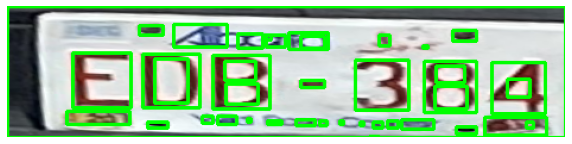

In [174]:
for i in range(len(cont)):            
    print (cv2.boundingRect(cont[i]))
    print (hierarchy[0][i], '\n')

# creat a copy version "test_roi" of plat_image to draw bounding box
test_roi = plate_image.copy()

# Initialize a list which will be used to append charater image
crop_characters = []

# define standard width and height of character
digit_w, digit_h = 30, 60

for c in sort_contours(cont):
    (x, y, w, h) = cv2.boundingRect(c)
    ratio = h/w

    # Draw bounding box arroung digit number
    cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

    # Sperate number and gibe prediction
    curr_num = thre_mor[y:y+h,x:x+w]
    curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
    _, curr_num = cv2.threshold(curr_num, 220, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    crop_characters.append(curr_num)

print("Detect {} letters...".format(len(crop_characters)))
fig = plt.figure(figsize=(10,6))
plt.axis(False)
plt.imshow(test_roi)
#plt.savefig('grab_digit_contour.png',dpi=300)

In [71]:
len(cont)

1

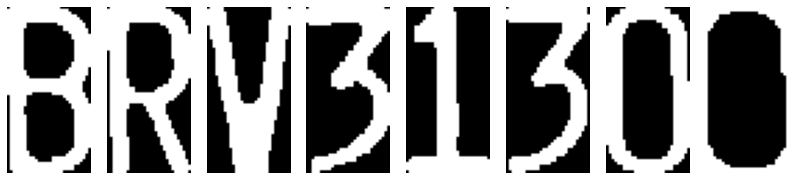

In [61]:
fig = plt.figure(figsize=(14,4))
grid = gridspec.GridSpec(ncols=len(crop_characters),nrows=1,figure=fig)

for i in range(len(crop_characters)):
    fig.add_subplot(grid[i])
    plt.axis(False)
    plt.imshow(crop_characters[i],cmap="gray")
#plt.savefig("segmented_leter.png",dpi=300)    

## Load pre-trained MobileNets model and predict

In [14]:
# Load model architecture, weight and labels
json_file = open('MobileNets_character_recognition.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_weight.h5")
print("[INFO] Model loaded successfully...")

labels = LabelEncoder()
labels.classes_ = np.load('license_character_classes.npy')
print("[INFO] Labels loaded successfully...")

[INFO] Model loaded successfully...
[INFO] Labels loaded successfully...


In [15]:
# pre-processing input images and pedict with model
def predict_from_model(image,model,labels):
    image = cv2.resize(image,(80,80))
    image = np.stack((image,)*3, axis=-1)
    prediction = labels.inverse_transform([np.argmax(model.predict(image[np.newaxis,:]))])
    return prediction

CPY648


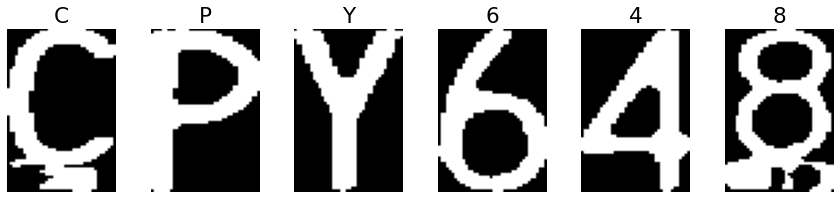

In [191]:
fig = plt.figure(figsize=(15,3))
cols = len(crop_characters)
grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

final_string = ''
for i,character in enumerate(crop_characters):
    fig.add_subplot(grid[i])
    title = np.array2string(predict_from_model(character,model,labels))
    plt.title('{}'.format(title.strip("'[]"),fontsize=20))
    final_string+=title.strip("'[]")
    plt.axis(False)
    plt.imshow(character,cmap='gray')

print(final_string)
#plt.savefig('final_result.png', dpi=300)

In [227]:
def lp_detect_segment_predict(test_image_path):
    
    vehicle, LpImg,cor = get_plate(test_image_path, 600, 400)
    
    fig = plt.figure(figsize=(12,6))
    grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
    fig.add_subplot(grid[0])
    plt.axis(False)
    plt.imshow(vehicle)
    grid = gridspec.GridSpec(ncols=2,nrows=1,figure=fig)
    fig.add_subplot(grid[1])
    plt.axis(False)
    plt.imshow(LpImg[0])
    
    if not (len(LpImg)): #check if there is at least one license image
        print ("No license plate detected!!!")
        return None
    
    # Scales, calculates absolute values, and converts the result to 8-bit.
    plate_image = cv2.convertScaleAbs(LpImg[0], alpha=(255.0))
    
    # convert to grayscale and blur the image
    gray = cv2.cvtColor(plate_image, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray,(7,7),0)
    
    # Applied inversed thresh_binary 
    binary = cv2.threshold(blur, 180, 255,
                         cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]
    kernel3 = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
    thre_mor = cv2.morphologyEx(binary, cv2.MORPH_DILATE, kernel3)
    
    # Find contours
    cont, hierarchy  = cv2.findContours(binary, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    
    cont_new = []
    H, W =binary.shape
    for index, c in enumerate(cont):
        (x, y, w, h) = cv2.boundingRect(c)
        if x<=1 or (W-x-w)<=1 or y<=1 or (H-y-h)<=1: continue   # Remove the contours close to the edge of image

        ratio = h/w
        if 0.6<=ratio<=5: # Only select contour with defined ratio
            if h/plate_image.shape[0]>=0.3: # Select contour which has the height larger than 50% of the plate
                if hierarchy[0][index][3]==-1:  # Neglect the inner contors of the characters.
                    cont_new.append(c)

                    
    # creat a copy version "test_roi" of plat_image to draw bounding box
    test_roi = plate_image.copy()
    # Initialize a list which will be used to append charater image
    crop_characters = []
    # define standard width and height of character
    digit_w, digit_h = 30, 60

    for c in sort_contours(cont_new):
        (x, y, w, h) = cv2.boundingRect(c)
        # Draw bounding box arroung digit number
        cv2.rectangle(test_roi, (x, y), (x + w, y + h), (0, 255,0), 2)

        # Seperate number and gibe prediction
        curr_num = thre_mor[y:y+h,x:x+w]
        curr_num = cv2.resize(curr_num, dsize=(digit_w, digit_h))
        curr_num = cv2.threshold(curr_num, 180, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
        crop_characters.append(curr_num)

    print("Detect {} letters...".format(len(crop_characters)))
#     fig = plt.figure(figsize=(10,6))
#     plt.axis(False)
#     plt.imshow(test_roi)
    
#     fig = plt.figure(figsize=(15,3))
#     cols = len(crop_characters)
#     grid = gridspec.GridSpec(ncols=cols,nrows=1,figure=fig)

    final_string = ''
    for i,character in enumerate(crop_characters):
#         fig.add_subplot(grid[i])
        title = np.array2string(predict_from_model(character,model,labels))
#         plt.title('{}'.format(title.strip("'[]"),fontsize=20))
        final_string+=title.strip("'[]")
#         plt.axis(False)
#         plt.imshow(character,cmap='gray')

    print(final_string, '\n')
    return final_string

Detect 6 letters...
EDC685 



'EDC685'

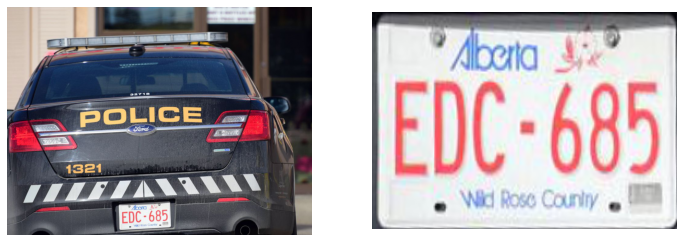

In [232]:
lp_detect_segment_predict("Plate_examples/alberta_licence/test7.jpeg")

Found 10 images...
Detect 7 letters...
BKM5115 

Detect 7 letters...
CGK6175 

Detect 6 letters...
GXU641 

Detect 6 letters...
CPY648 

Detect 7 letters...
0SANDHU 

Detect 7 letters...
BRH8146 

Detect 6 letters...
YYC403 

Detect 6 letters...
EDB384 

Detect 6 letters...
EDB384 

Detect 6 letters...
EJS203 



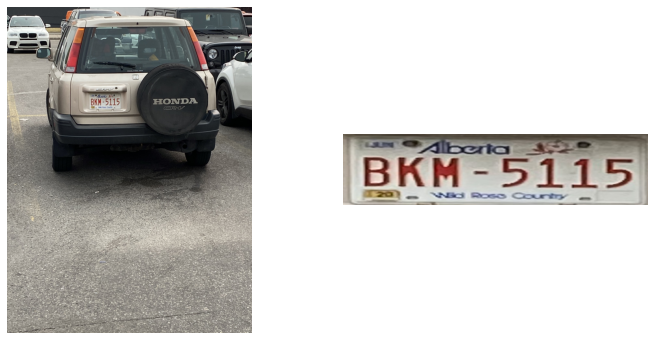

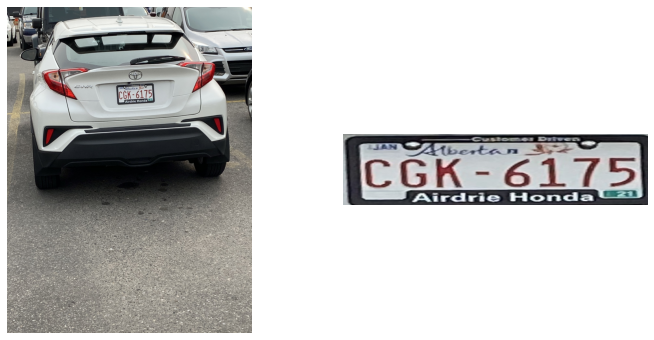

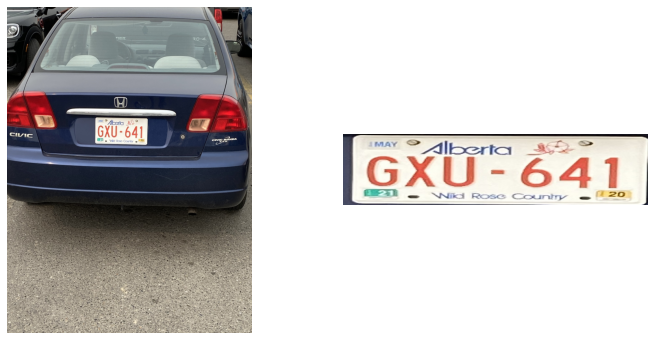

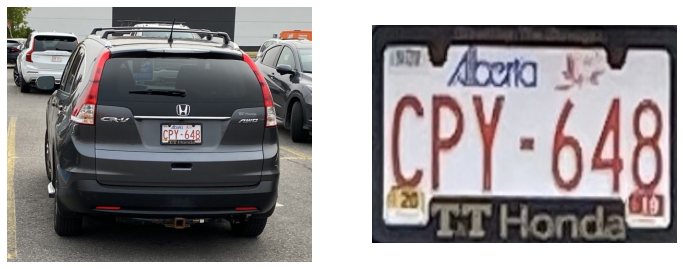

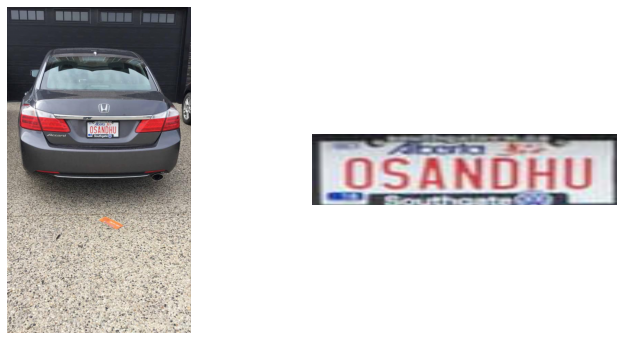

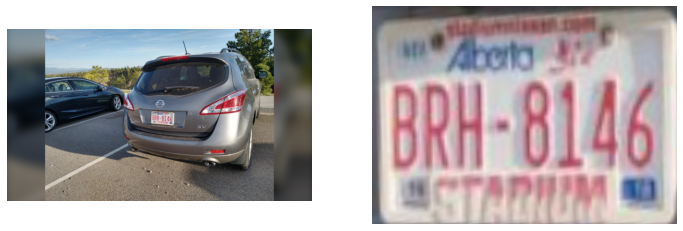

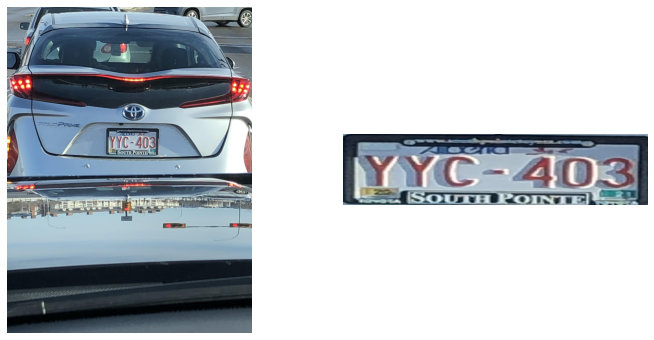

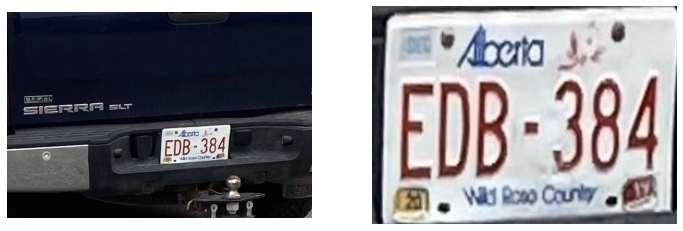

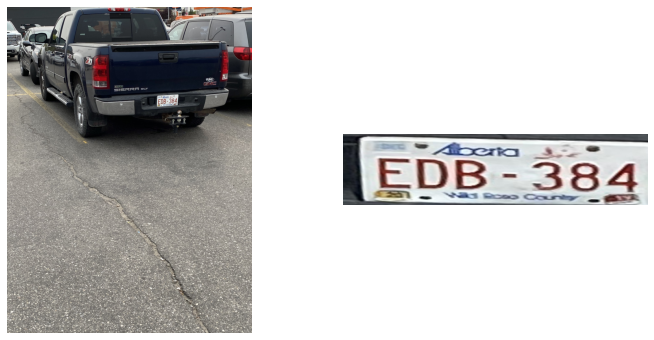

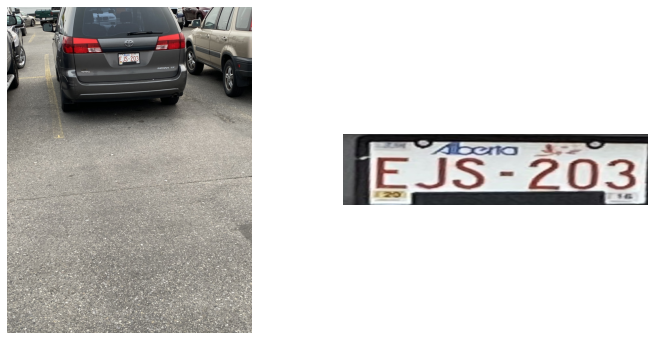

In [231]:
# Create a list of image paths 
image_paths = glob.glob("Plate_examples/alberta_licence/*.jpg")
print("Found %i images..."%(len(image_paths)))

for image_path in image_paths:
    try:
        lp_detect_segment_predict(image_path)
    except Exception as e:
        print (e)
        print (image_path, " not detected!", '\n')
        continue